In [1]:
import numpy as np
from cmaes import CMA
import matplotlib.pyplot as plt
import itertools

from quantify_core.data.handling import (
    default_datadir,
    get_latest_tuid,
    load_dataset,
    locate_experiment_container,
    set_datadir,
)

In [2]:
set_datadir(default_datadir())

Data will be saved in:
/home/pschaefers/quantify-data


In [3]:
tuid = get_latest_tuid(contains="Single-shot")
dataset = load_dataset(tuid)

In [4]:
duration = dataset.x0.data
frequency = dataset.x1.data
amplitude = dataset.x2.data
average_fidelity = dataset.y0.data

QND_pi_fidelity = dataset.y5.data

freq_reshape = []
amplitude_reshape = []
average_fidelity_reshape = []
QND_pi_fidelity_reshape = []

# Count occurrences
unique_duration_values, counts = np.unique(duration, return_counts=True)

for i in unique_duration_values:
    indices = np.where(duration == i)
    freq_reshape.append(frequency[indices])
    amplitude_reshape.append(amplitude[indices])
    average_fidelity_reshape.append(average_fidelity[indices])
    QND_pi_fidelity_reshape.append(QND_pi_fidelity[indices])

In [5]:
#For now just work with longest duration data:
duration = unique_duration_values[-1]
frequency_test = freq_reshape[-1]
amplitude_test = amplitude_reshape[-1]
average_fidelity_test = average_fidelity_reshape[-1]

In [6]:
def plotSingleFidelity(frequency: np.ndarray, amplitude: np.ndarray, fidelity: np.ndarray, title: str) -> None:
    """
    Plot a single heatmap using imshow for frequency, amplitude, and fidelity.
    """
    # Reshape fidelity to 2D (if not already a grid)
    Z = fidelity.reshape(int(np.sqrt(len(amplitude))), int(np.sqrt(len(frequency))))

    # Calculate the extent of the axes for imshow
    dx = (frequency.max() - frequency.min()) / (Z.shape[1] - 1)  # Step size along x-axis
    dy = (amplitude.max() - amplitude.min()) / (Z.shape[0] - 1)  # Step size along y-axis

    extent = [
        frequency.min() - 0.5 * dx, frequency.max() + 0.5 * dx,  # x-axis range
        amplitude.min() - 0.5 * dy, amplitude.max() + 0.5 * dy   # y-axis range
    ]

    # Plot with imshow
    plt.figure(figsize=(10, 8), dpi=300)
    cmap = 'viridis'
    vmin, vmax = 0.5, 1  # Set fidelity range for consistent scaling

    im = plt.imshow(Z, extent=extent, origin='lower', aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, label="Fidelity")
    plt.title(title, fontsize=16)
    plt.xlabel("Frequency [Hz]", fontsize=12)
    plt.ylabel("Amplitude [V]", fontsize=12)
    plt.show()

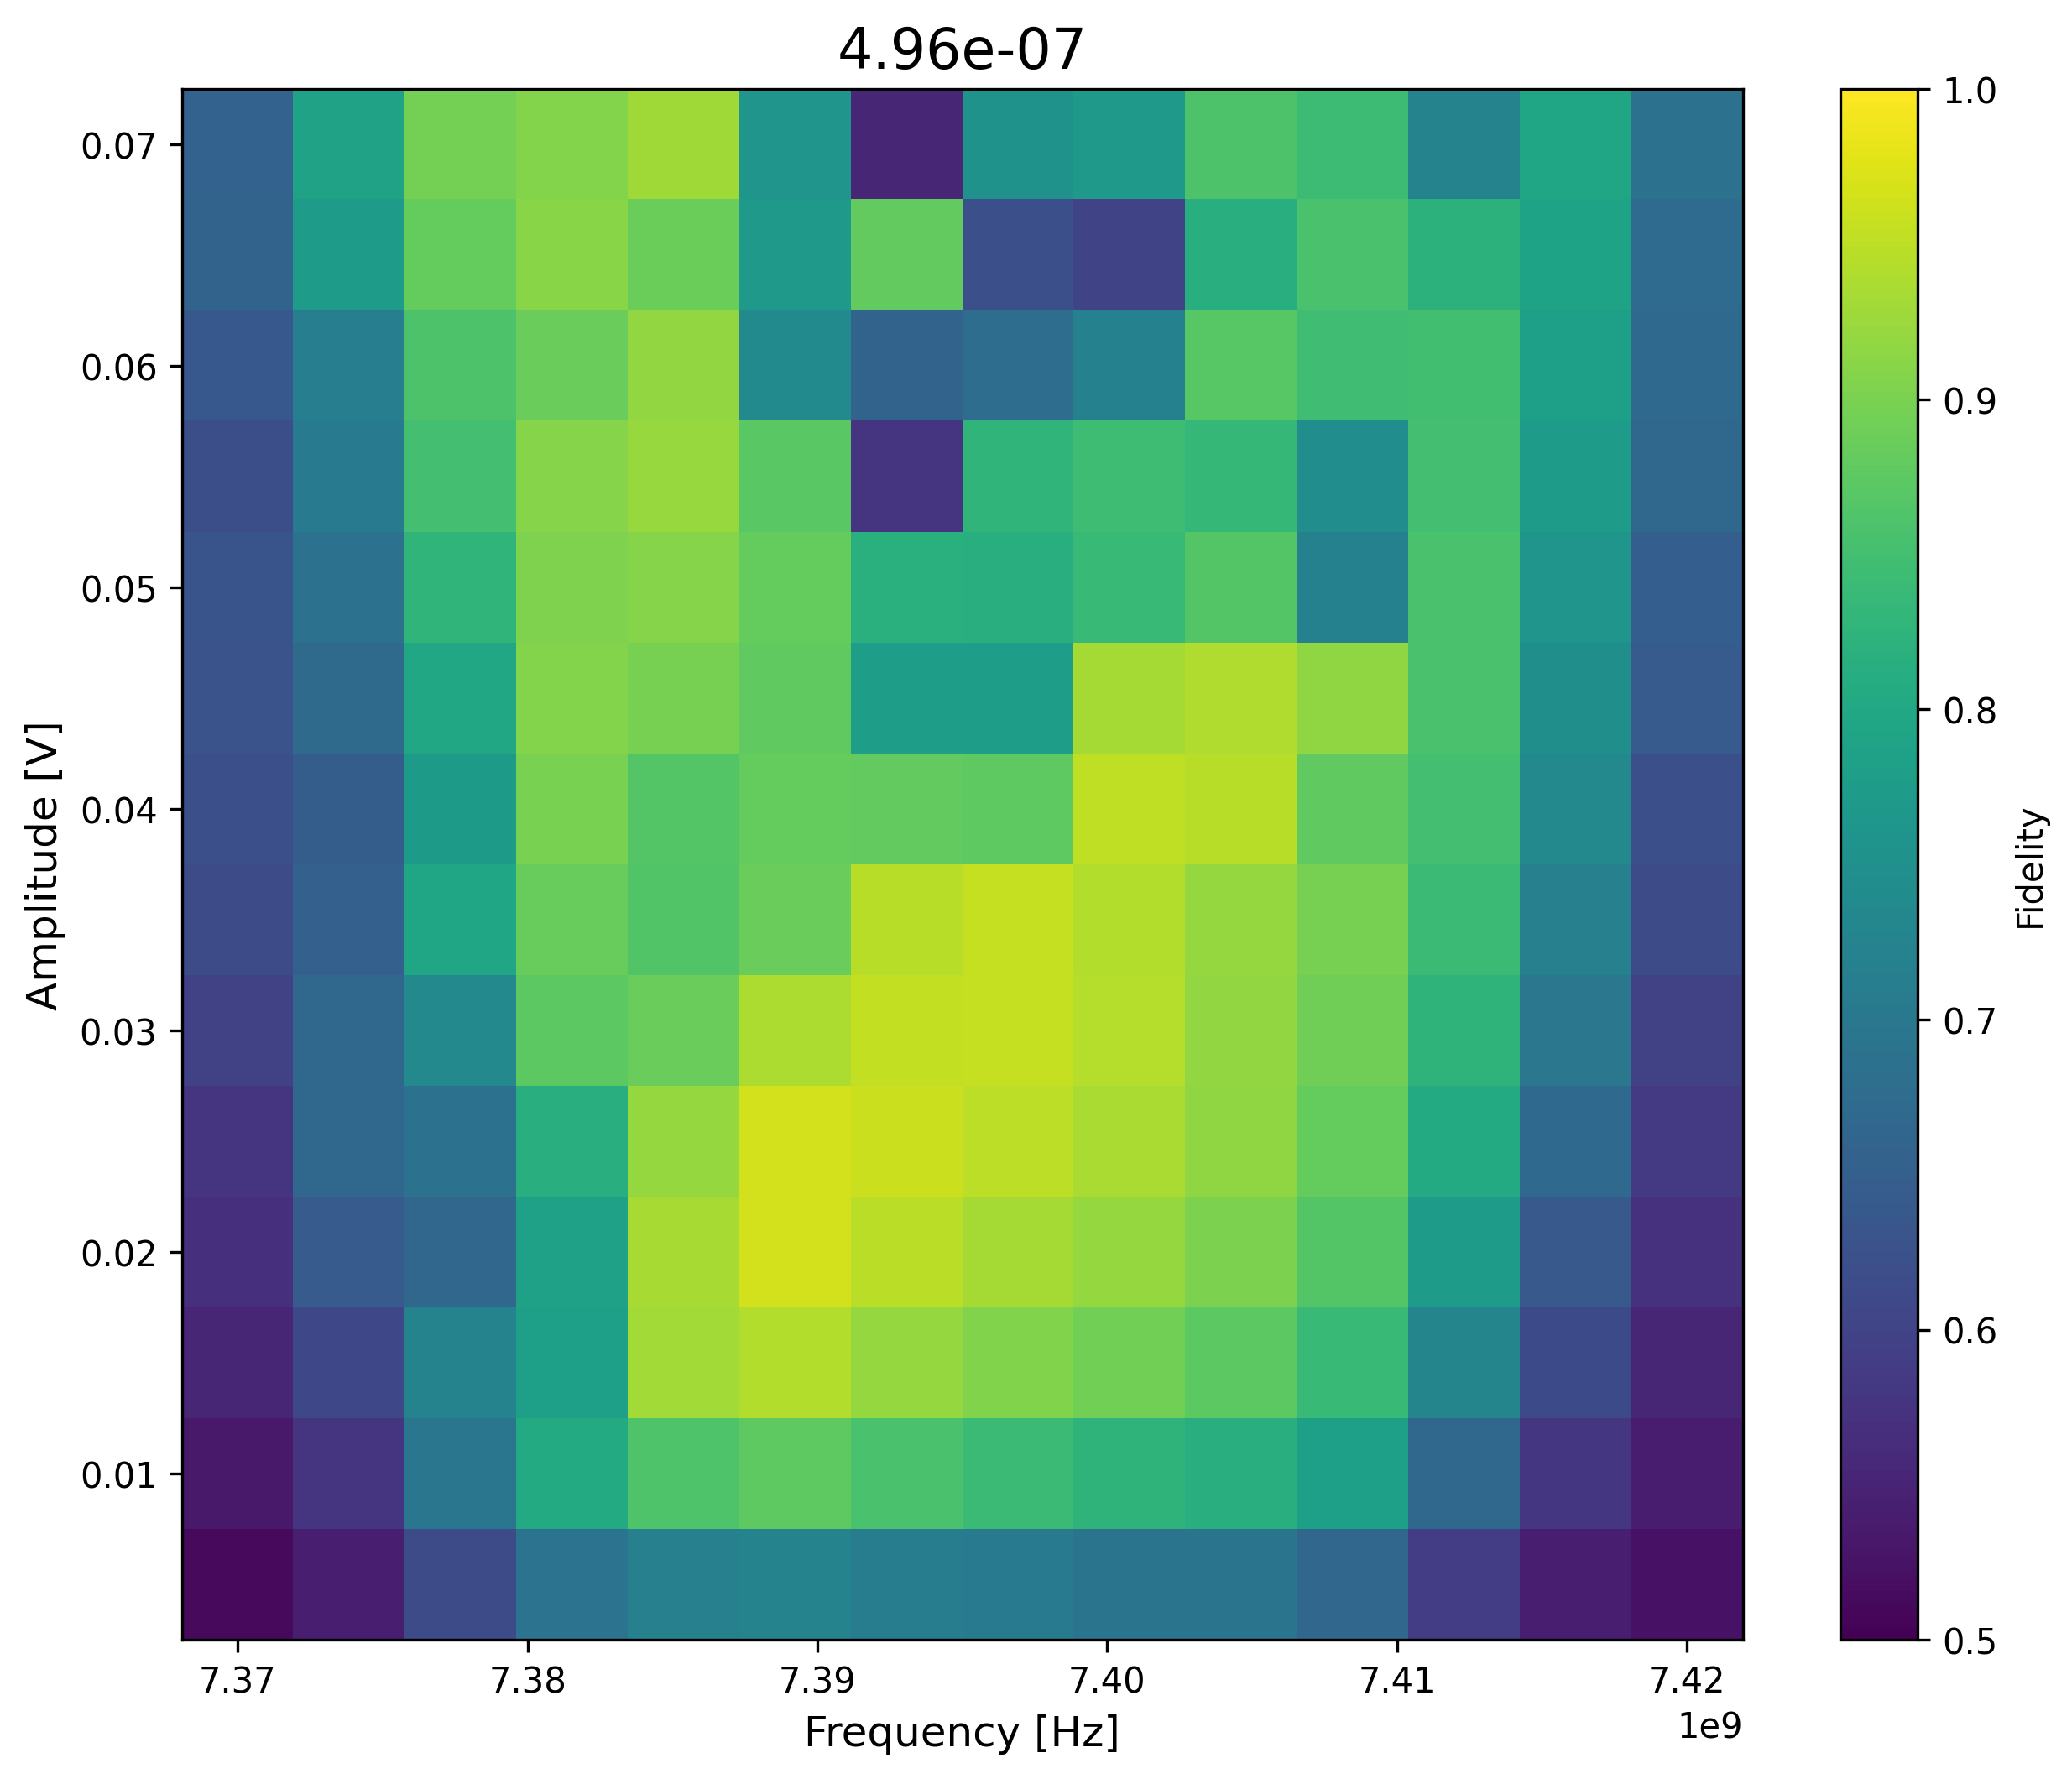

In [7]:
plotSingleFidelity(frequency_test,amplitude_test,average_fidelity_test,str(duration))

In [8]:
def fidelityEstimate(point,frequency,amplitude,fidelity):
    # Get unique values of frequency and amplitude
    unique_freq = np.unique(frequency)
    unique_ampl = np.unique(amplitude)
    
    # Get the closest 2 unique frequencies and amplitudes
    dFreq = np.abs(unique_freq - point[0])
    dAmpl = np.abs(unique_ampl - point[1])
    
    freqArgs = np.argsort(dFreq)[:2]
    amplArgs = np.argsort(dAmpl)[:2]
    
    x_coor = unique_freq[freqArgs]
    y_coor = unique_ampl[amplArgs]
    
    # Sort the coordinates
    sortedX = np.sort(x_coor)
    sortedY = np.sort(y_coor)
    
    # Calculate differences
    dx = np.diff(sortedX)
    dy = np.diff(sortedY)
    
    fidelities = []
    
    for i in itertools.product(sortedX,sortedY):
        temp1 = np.where(i[0] == frequency)
        temp2 = np.where(i[1] == amplitude)
        arg = np.intersect1d(temp1,temp2)
        fidelities.append(fidelity[arg])
    
    fidelities = np.array(fidelities)
    
    # Reshape fidelities into a 2x2 grid for interpolation
    fidelity_matrix = fidelities.reshape((2, 2))
    # print(fidelity_matrix)
    
    # Bilinear interpolation formula
    result = (fidelity_matrix[0, 0] * (sortedX[1] - point[0]) * (sortedY[1] - point[1]) +
              fidelity_matrix[1, 0] * (point[0] - sortedX[0]) * (sortedY[1] - point[1]) +
              fidelity_matrix[0, 1] * (sortedX[1] - point[0]) * (point[1] - sortedY[0]) +
              fidelity_matrix[1, 1] * (point[0] - sortedX[0]) * (point[1] - sortedY[0])) / (dx * dy)

    return result

61


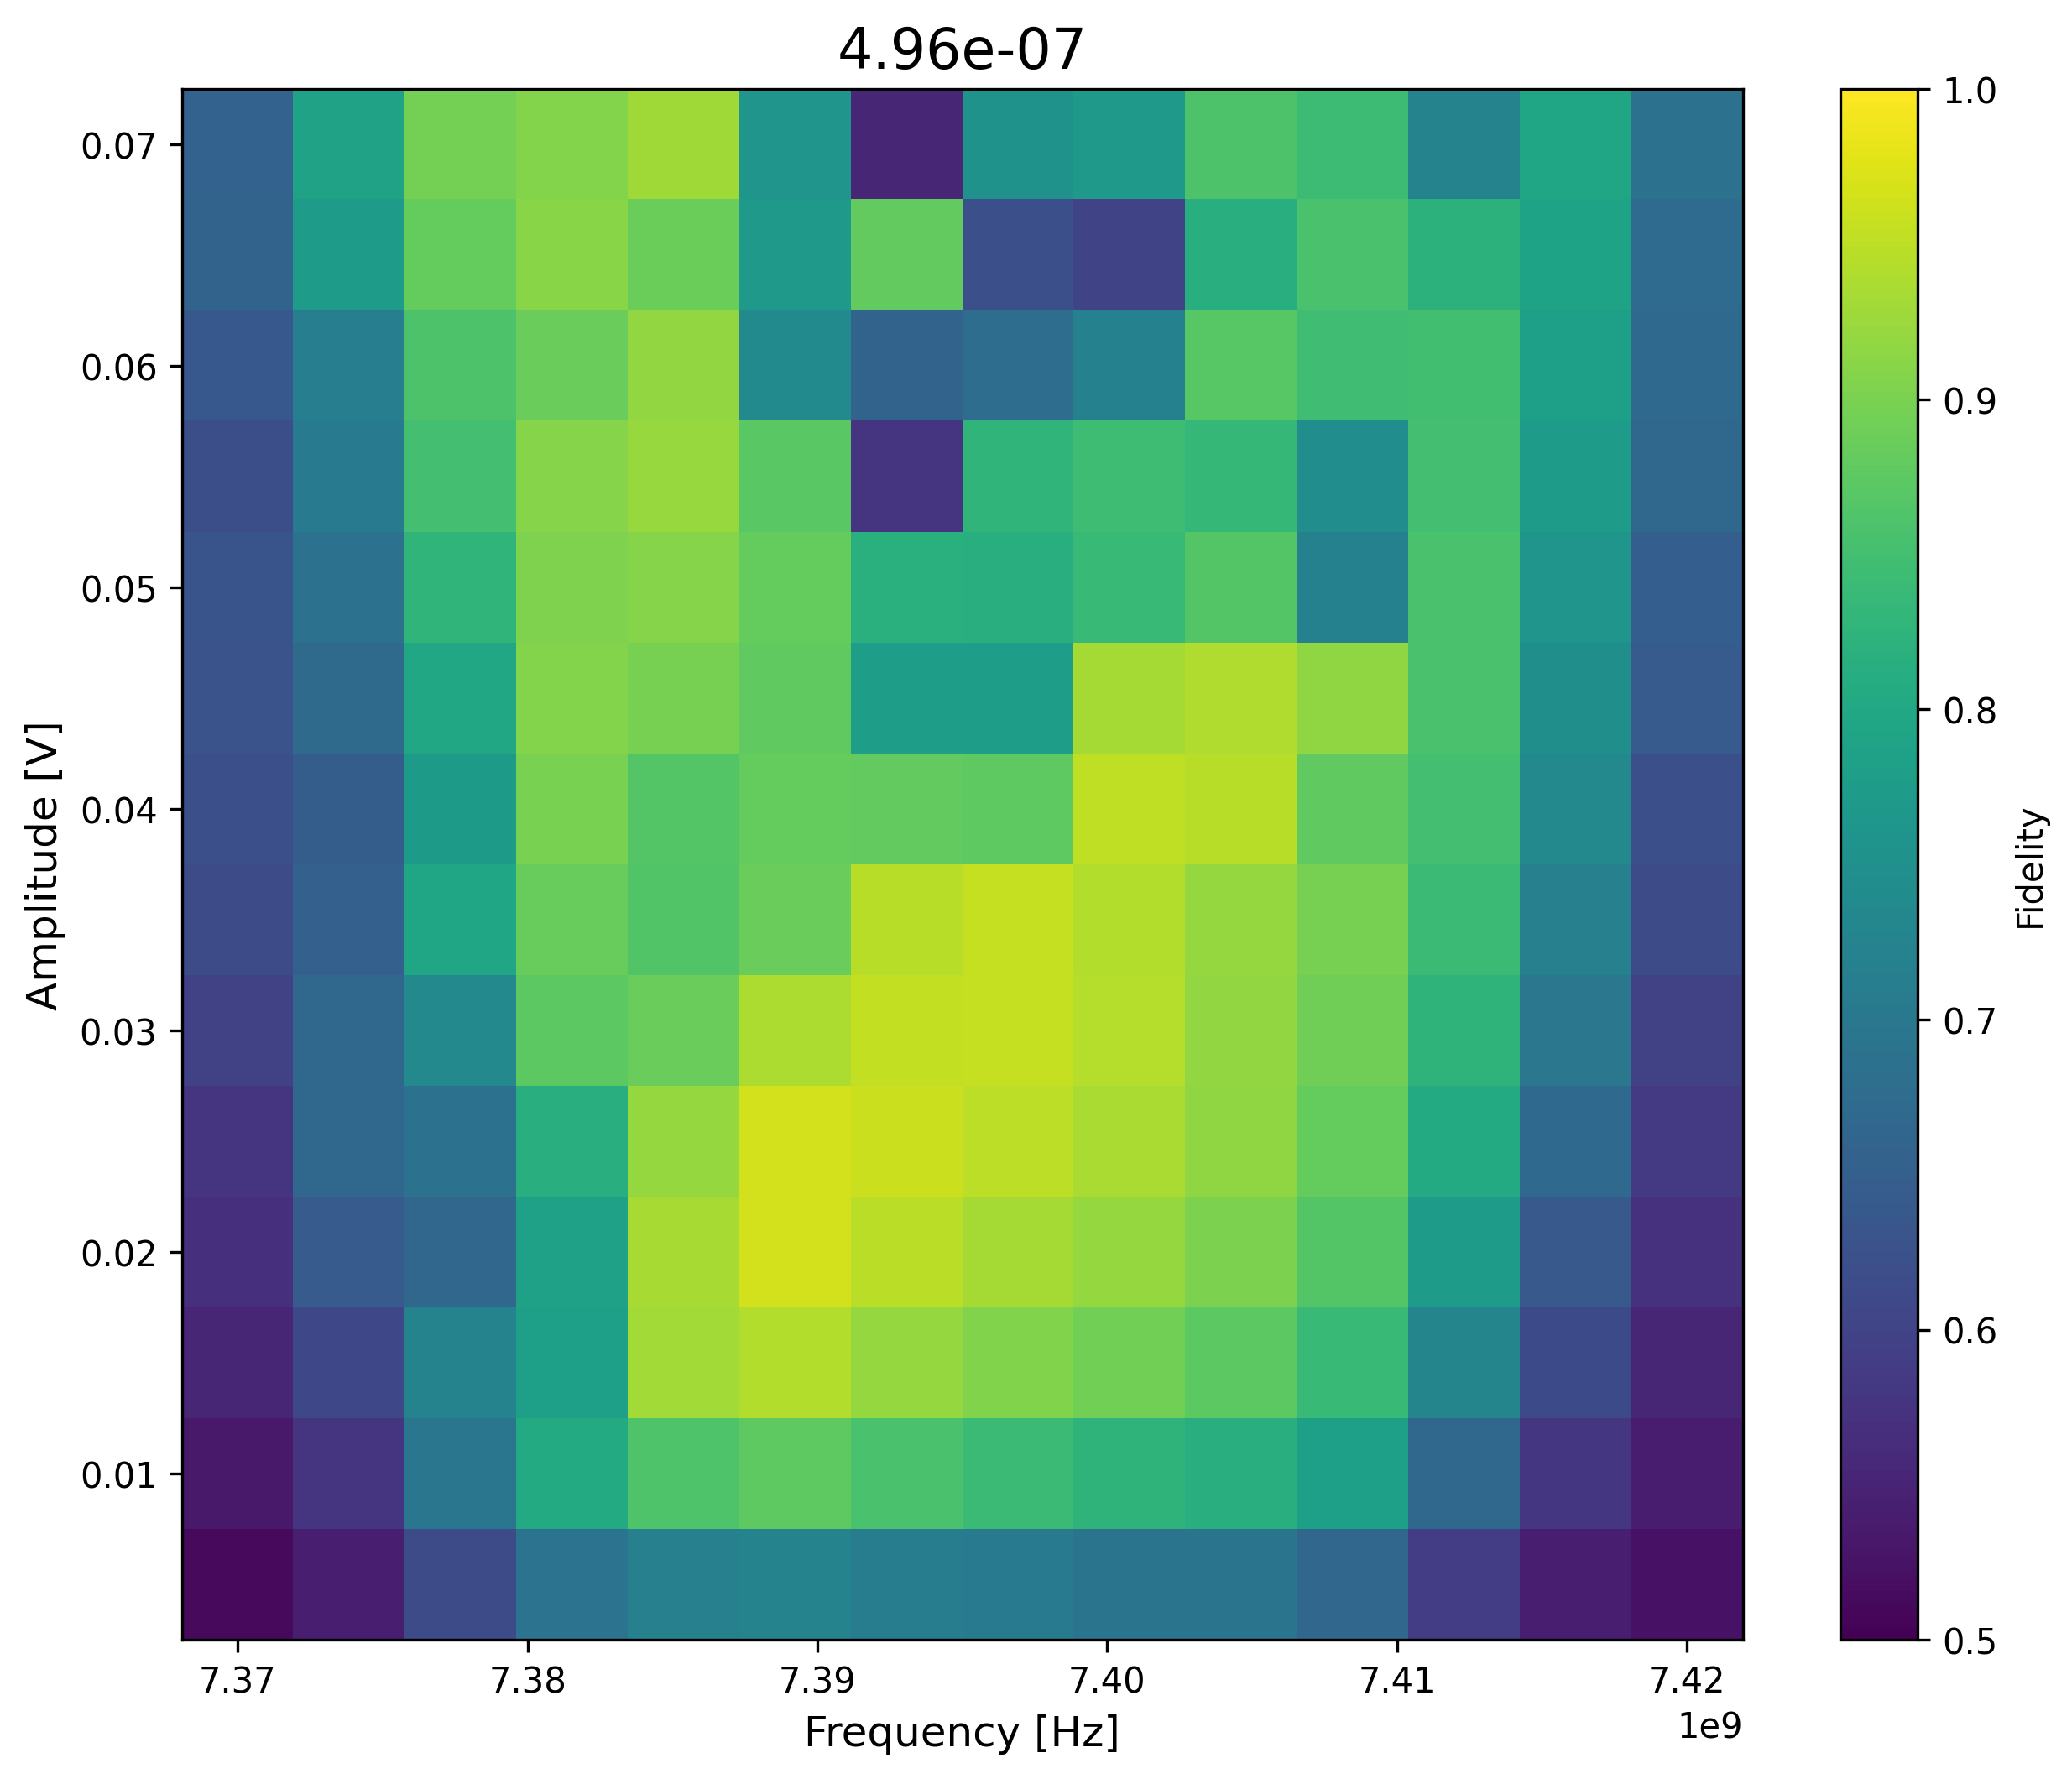

In [9]:
x = np.linspace(min(frequency_test),max(frequency_test),14)
y = np.linspace(min(amplitude_test),max(amplitude_test),14)

X0 = np.array(list(itertools.product(y,x)))
x = X0[:,1]
y = X0[:,0]

# print(amplitude_test)
# print(x)
# print(y)

# # x = frequency_test
# # y = amplitude_test

points = np.column_stack((x,y))
# print(points.shape)
# print(np.unique(points[:, 0]))
# print(np.unique(points[:, 1]))

fidelity_estimates = []

for point in points:
    estimate = fidelityEstimate(point, frequency_test, amplitude_test, average_fidelity_test)
    fidelity_estimates.append(estimate)

print(np.argmax(fidelity_estimates))
# print(len(fidelity_estimates))
plotSingleFidelity(x,y,np.array(fidelity_estimates),str(duration))

61


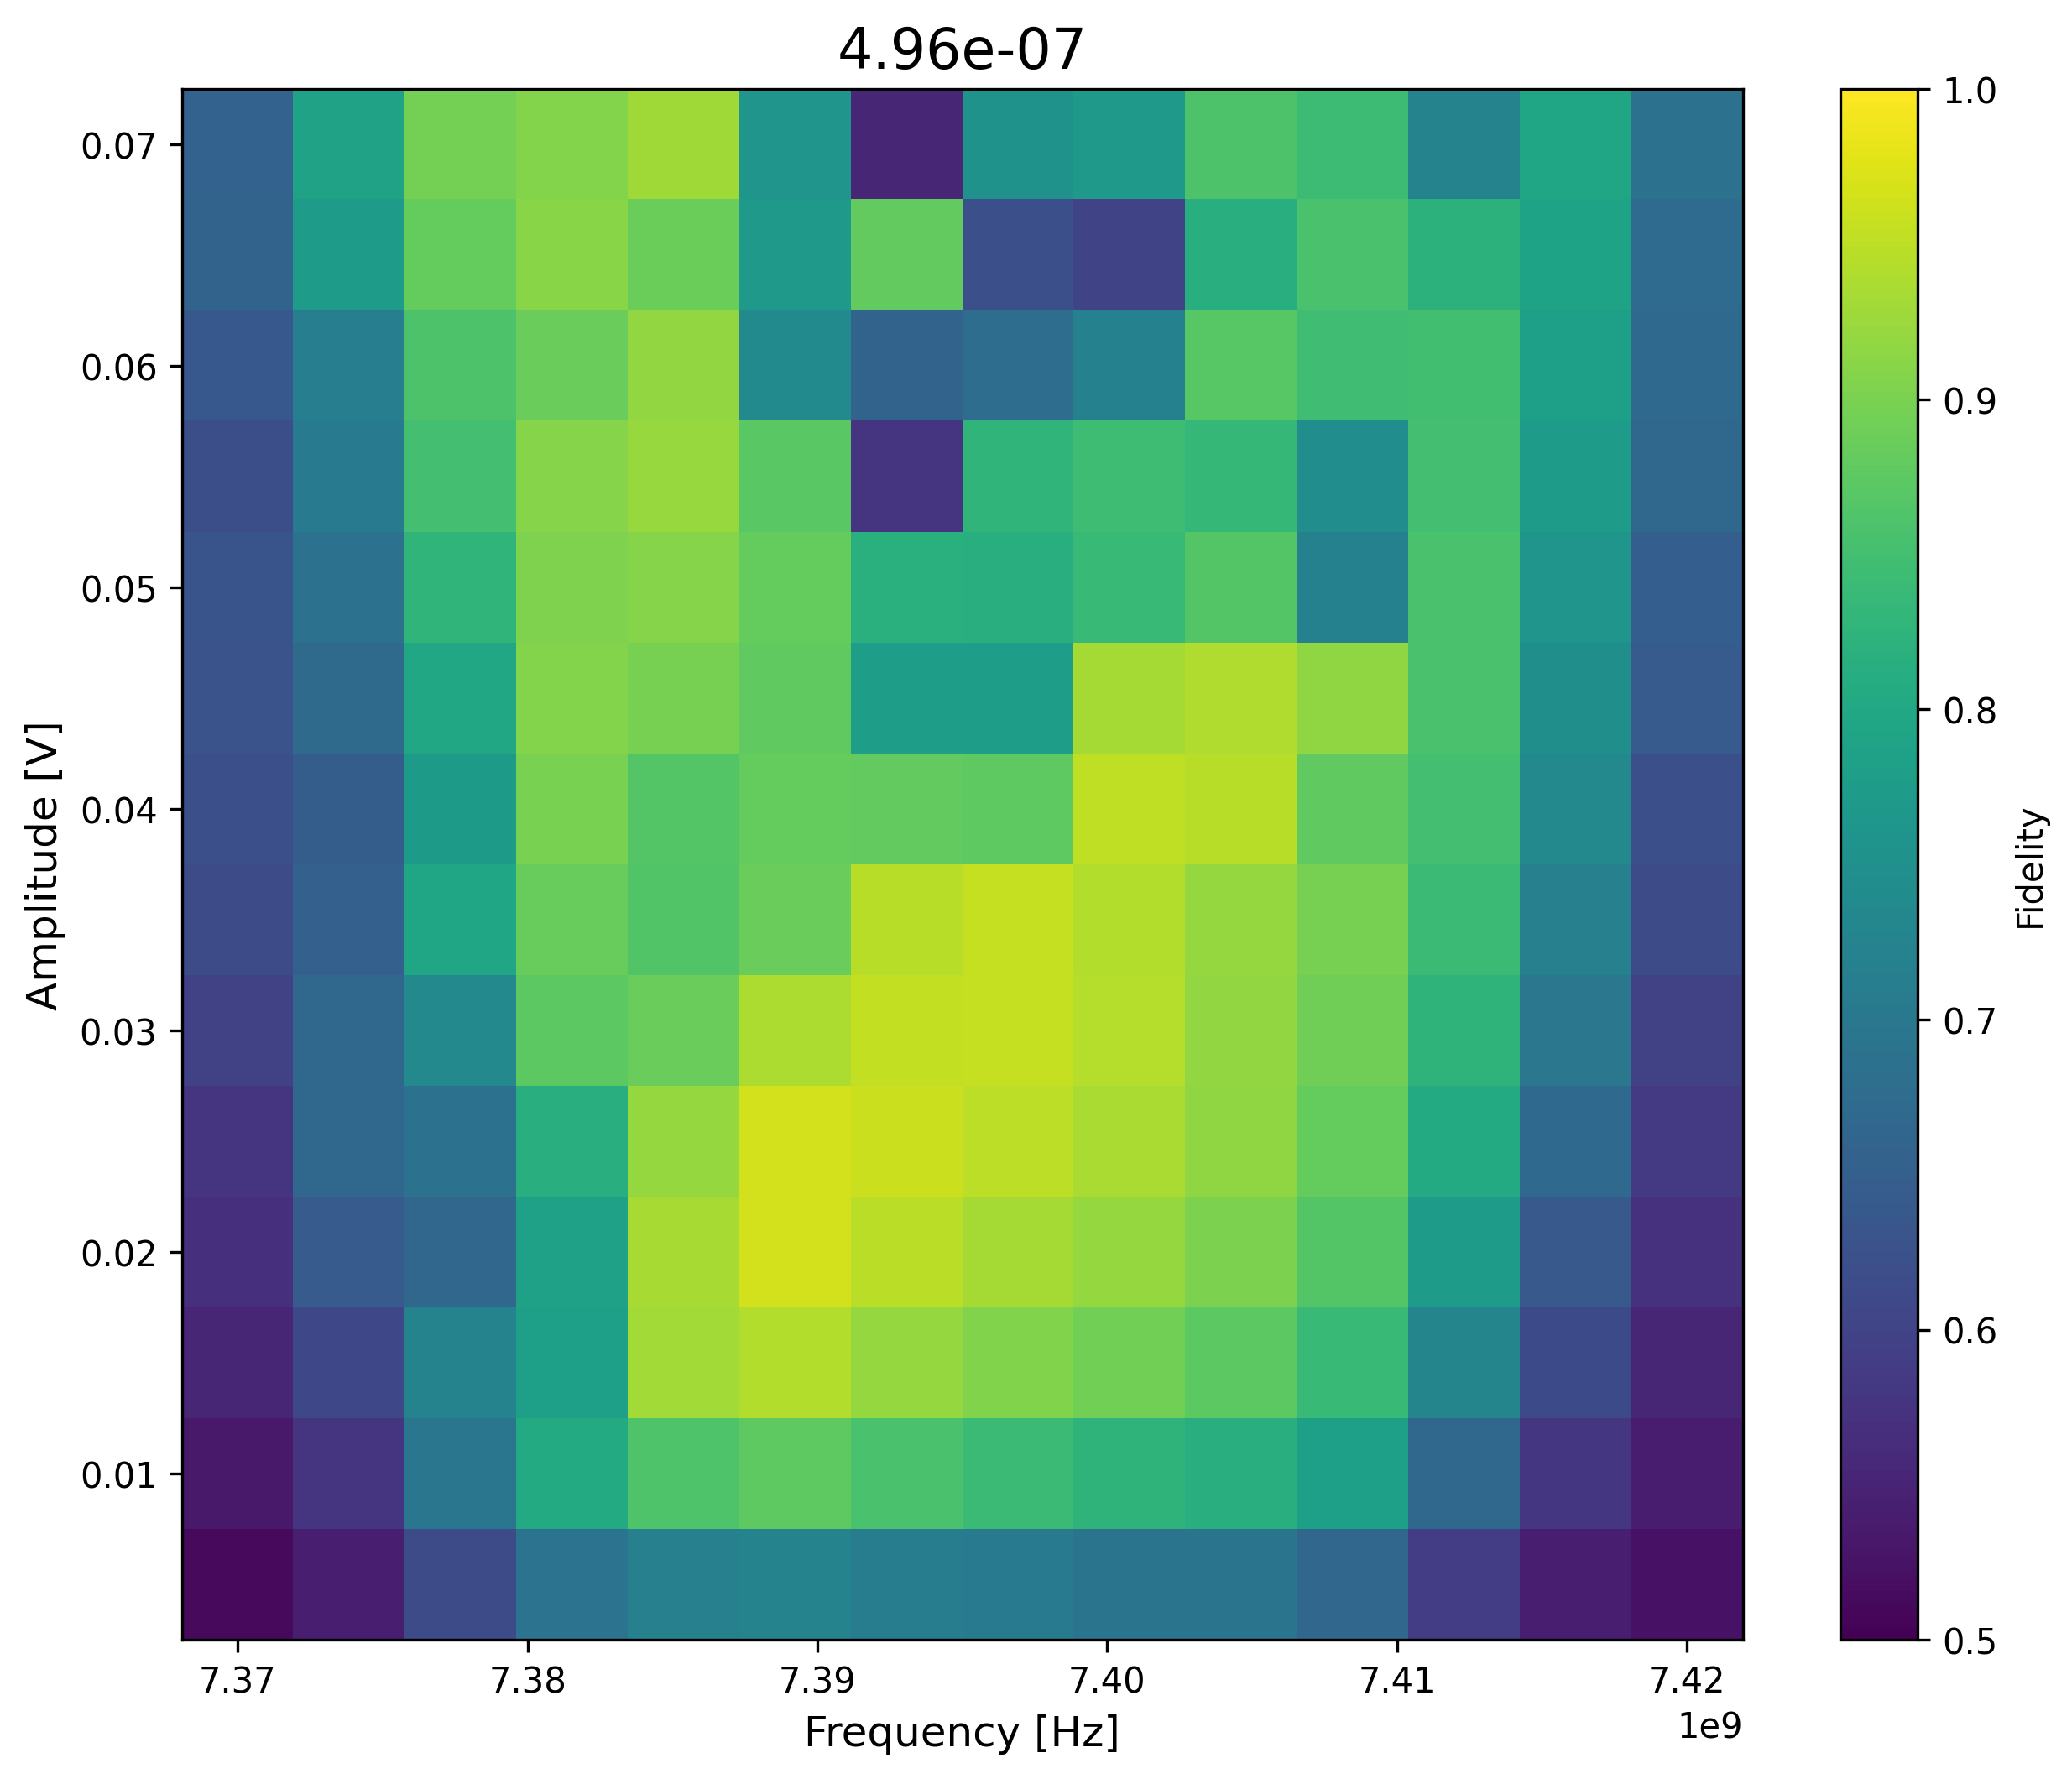

In [10]:
x = np.linspace(min(frequency_test),max(frequency_test),14)
y = np.linspace(min(amplitude_test),max(amplitude_test),14)

X0 = np.array(list(itertools.product(y,x)))
x = X0[:,1]
y = X0[:,0]

# print(amplitude_test)
# print(x)
# print(y)

# # x = frequency_test
# # y = amplitude_test

points = np.column_stack((x,y))
# print(points.shape)
# print(np.unique(points[:, 0]))
# print(np.unique(points[:, 1]))

fidelity_estimates = []

for point in points:
    estimate = fidelityEstimate(point, frequency_test, amplitude_test, average_fidelity_test)
    fidelity_estimates.append(estimate)

print(np.argmax(fidelity_estimates))
# print(len(fidelity_estimates))
plotSingleFidelity(x,y,np.array(fidelity_estimates),str(duration))

In [42]:
def objective(point,frequency,amplitude,fidelity):
    F = fidelityEstimate(point, frequency, amplitude, fidelity)
    return np.log(1-F)

popsize = 3
sigma = 10 #stepsize 

# boundX = [min(frequency_test),max(frequency_test)]
# boundY = [min(amplitude_test),max(amplitude_test)]
# bounds = np.array([boundX,boundY])

# mean = np.array([np.mean(frequency_test), np.mean(amplitude_test)])

boundX = [0,1]
boundY = [0,1]
bounds = np.array([boundX,boundY])

mean = np.array([0.5,0.5])

optimizer = CMA(mean=mean, sigma=sigma, population_size=popsize,bounds=bounds)

print(optimizer._c_sigma)
print(optimizer._d_sigma)


minFreq = min(frequency_test)
maxFreq = max(frequency_test)
deltaFreq = maxFreq-minFreq

minAmpl = min(amplitude_test)
maxAmpl = max(amplitude_test)
deltaAmpl = maxAmpl-minAmpl

#x[0] = frequency, x[1] = amplitude
for generation in range(10):
    solutions = []
    for _ in range(optimizer.population_size):
        x = optimizer.ask()
        print("before ", optimizer._sigma)
        x_hat = np.copy(x)
        x_hat[0] = x_hat[0]*deltaFreq+minFreq
        x_hat[1] = x_hat[1]*deltaAmpl+minAmpl

        value = objective(x_hat,frequency_test, amplitude_test,average_fidelity_test)
        solutions.append((x_hat,value))
        print("after ", optimizer._sigma)

        # print(f"{generation=} {value=} {x_hat=}  {x=}")
    optimizer.tell(solutions)


0.375
1.375
before  10
after  10
before  10
after  10
before  10
after  10
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32
before  1e+32
after  1e+32


In [12]:
point = solutions[0][0]
result = fidelityEstimate(point, frequency_test, amplitude_test, average_fidelity_test)
print(result)

[0.65748818]


In [13]:
print(x)
x_hat = np.copy(x)
x_hat[0] = (x_hat[0] - min(frequency_test))/(max(frequency_test)-min(frequency_test))

print(x_hat)

x_hat[0] = x_hat[0]*deltaFreq+minFreq
print(x_hat)

[1. 0.]
[-147.39999998    0.        ]
[1.00000095 0.        ]


In [23]:
print(min(frequency_test))

7370000000.0
